# III - Prédiction de la popularité d’une musique

## Imports

In [1]:
import pandas as pd
import numpy as np
import pickle 

import matplotlib.pyplot as plt
# import plotly.graph_objects as go

In [2]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

In [3]:
DATA_DIR = '../data/'
DATA_PROCESSED_DIR = DATA_DIR + 'processed/'

## Partie 1 - Data preprocessing for regression

In [4]:
def load_pkl(pkl_file):
    with open(pkl_file, 'rb') as f:
        data = pickle.load(f)
    return data

In [5]:
pkl_file_X = DATA_PROCESSED_DIR + 'data_X.pkl' # X
df_X = load_pkl(pkl_file_X)
df_X = df_X.reset_index(drop=True)
df_X

pkl_file_y = DATA_PROCESSED_DIR + 'data_y.pkl' # y
df_y = load_pkl(pkl_file_y)
df_y = pd.DataFrame(df_y).reset_index(drop=True)
df_y

df = pd.concat([df_X, df_y], axis=1)
df['genre'] = LabelEncoder().fit_transform(df['genre'])
df

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre
0,0.714286,0.074497,0.514427,0.036654,0.879877,0.000000,0.090909,0.073583,0.906392,1.0,0.043103,0.515119,0.75,0.336694,1
1,0.744898,0.000728,0.791128,0.090401,0.703698,0.885312,0.000000,0.063765,0.773646,1.0,0.038739,0.467137,0.75,0.862903,1
2,0.755102,0.019377,0.595177,0.063311,0.697692,0.000000,0.181818,0.323887,0.792554,1.0,0.120471,0.430578,0.75,0.479839,1
3,0.775510,0.042770,0.792205,0.048370,0.811808,0.000001,0.545455,0.090081,0.785479,0.0,0.016805,0.397972,0.75,0.868952,1
4,0.724490,0.086043,0.551034,0.046592,0.763759,0.000003,0.090909,0.082186,0.883661,1.0,0.037866,0.563509,0.75,0.433468,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35534,0.612245,0.124497,0.615633,0.042062,0.688682,0.000048,0.181818,0.147773,0.768197,1.0,0.004365,0.440658,0.75,0.900202,4
35535,0.571429,0.203814,0.599483,0.051806,0.401389,0.000000,0.363636,0.074899,0.681705,0.0,0.030663,0.261384,0.75,0.677419,4
35536,0.510204,0.033634,0.361542,0.051346,0.682676,0.000232,0.909091,0.298583,0.724362,1.0,0.096464,0.323079,0.75,0.363911,4
35537,0.591837,0.138553,0.645780,0.020947,0.537528,0.000000,0.545455,0.045749,0.814574,0.0,0.008839,0.476109,0.75,0.894153,4


In [7]:
# df = df[df['genre']!=df['genre'].value_counts().argmin()]
# df['genre'].value_counts()

In [41]:
# Saving feature names for later use
feature_list = list(df.columns)[1:]
feature_list

['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'time_signature',
 'valence',
 'genre']

##### Split data into train/test dataset

##### Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called **overfitting**. To avoid it, the dataset is split into 2 smaller dataset:  training dataset (X_train, y_train) and test dataset (X_test, y_test).

In [8]:
def split_data(df, target_col, test_size=0.20, random_state=42):
    """ Split data for training/validation part """
    y = df[[target_col]]
    X = df.drop(columns=[target_col])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [9]:
target_col = 'popularity'
X_train, X_test, y_train, y_test = split_data(df, target_col, test_size=0.33)

X_train = X_train.to_numpy()
y_train = y_train.to_numpy().ravel()

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")

print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (23811, 14)
y_train.shape: (23811,)
X_test.shape: (11728, 14)
y_test.shape: (11728, 1)


In [2]:
# data_type2feature = {
#     'metadata': ['track_id', 'artists_name', 'album_name', 'track_name', 'track_popularity'],
#     'audio': {
#         'mood': ['danceability', 'valence', 'energy', 'tempo'],
#         'properties': ['loudness', 'speechiness', 'instrumentalness'],
#         'content': ['duration_ms', 'liveness', 'acousticness'],
#         'metadata': ['explicit', 'key', 'mode', 'time_signature']
#     },
#     'text': ['track_genre']
# }

# data_type_detailed2feature = {
#     'metadata': ['track_id', 'artists_name', 'album_name', 'track_name', 'track_popularity'],
#     'audio_mood': ['danceability', 'valence', 'energy', 'tempo'],
#     'audio_properties': ['loudness', 'speechiness', 'instrumentalness'],
#     'audio_content': ['duration_ms', 'liveness', 'acousticness'],
#     'audio_metadata': ['explicit', 'key', 'mode', 'time_signature'],
#     'text': ['track_genre']
# }

# feature2data_type = {
#     'track_id': 'metadata',
#     'artists_name': 'metadata',
#     'album_name': 'metadata', 
#     'track_name':'metadata',
#     'track_popularity': 'metadata',
#     'danceability': 'audio', 
#     'valence': 'audio', 
#     'energy': 'audio', 
#     'tempo': 'audio', 
#     'loudness': 'audio', 
#     'speechiness': 'audio',  
#     'instrumentalness': 'audio', 
#     'duration_ms': 'audio', 
#     'liveness': 'audio', 
#     'acousticness': 'audio', 
#     'explicit': 'audio', 
#     'key': 'audio', 
#     'mode': 'audio', 
#     'time_signature': 'audio', 
#     'track_genre': 'text'
# }

# feature2data_type_detailed = {
#     'track_id': 'metadata',
#     'artists_name': 'metadata',
#     'album_name': 'metadata', 
#     'track_name':'metadata',
#     'track_popularity': 'metadata',
#     'danceability': 'audio_mood', 
#     'valence': 'audio_mood', 
#     'energy': 'audio_mood', 
#     'tempo': 'audio_mood', 
#     'loudness': 'audio_properties', 
#     'speechiness': 'audio_properties',  
#     'instrumentalness': 'audio_properties', 
#     'duration_ms': 'audio_content', 
#     'liveness': 'audio_content', 
#     'acousticness': 'audio_content', 
#     'explicit': 'audio_metadata', 
#     'key': 'audio_metadata', 
#     'mode': 'audio_metadata', 
#     'time_signature': 'audio_metadata', 
#     'track_genre': 'text'
# }

# def conduct_features_importance(model_name, params, X_train, y_train):
#     """ Conduct features importance """
#     if model_name == 'random_forest':
#         model = RandomForestRegressor(**params[model_name])
#         model.fit(X_train, y_train)
        
#         # Retrieve scores and features name
#         scores = model.feature_importances_
#         features_name = model.feature_names_in_
#     else:
#         raise ValueError(f"Unknown model name: '{model_name}'")
    
#     return scores, features_name


# def plot_features_importance(scores, features_name, model_name, colors=['blue', 'red', 'green', 'purple', 'orange', 'pink']):
#     """ Plot features importance """
#     colors = {feature_name_group:colors[i] for i, feature_name_group in enumerate(list(set([feature2data_type_detailed[feat] for feat in features_name])))}
#     fig = go.Figure()
#     for feature_no, feature_name in enumerate(features_name):
#         fig.add_trace(
#             go.Bar(
#                 x=[scores[feature_no]],
#                 y=[feature_name],
#                 name=feature_name,
#                 orientation='h',
#                 text=f'{round(scores[feature_no], 4)}',
#                 # textposition='outside',
#                 hovertemplate=f'<b>Feature name:</b> {feature_name}<br><b>Feature name group:</b> {feature2data_type_detailed[feature_name]}<br><b>Score:</b> {round(scores[feature_no], 3)}',
#                 marker=dict(color=colors[feature2data_type_detailed[feature_name]]),
#                 legendgroup=feature2data_type_detailed[feature_name],
#                 legendgrouptitle_text=feature2data_type_detailed[feature_name]
#             )
#         )  

#     fig.update_layout(
#         title={'text':f"Features importances conducted by '{model_name.replace('_', ' ').title()}' model", 'x':0.5},
#         legend={'title':'Features name group'},
#         xaxis={'title':'Track popularity', 'categoryorder':'total ascending'},
#         yaxis={'title':'Feature name', 'categoryorder':'total ascending'},
#         uniformtext_minsize=10, uniformtext_mode='show',
        
#         width=1400, height = 800
#     )

#     return fig


# params = {
#     'random_forest': {
#         'n_estimators' : 150,
#         'criterion' : 'squared_error', 
#         'random_state' : 42
#     }
# }
# model_name = 'random_forest'
# scores, features_name = conduct_features_importance(model_name, params, X_train, y_train)

# fig = plot_features_importance(scores, features_name, model_name)
# fig.show()

## Partie 2 - Model selection by Cross Validation

#### Cross validation: evaluating estimator performance

##### When evaluating different settings (“hyperparameters”) for estimators, such as the C setting that must be manually set for an SVM, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.<br>

##### However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.<br>

##### A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:
- A model is trained using k-1 of the folds as training data;
- the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).<br>

##### The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.

<p align="center">
  <img src="../report/img/cross_validation.png" alt="Cross validation: evaluating estimator performance" height=400/>
  <img src="../report/img/kfold.png" alt="K-Fold" height=400/>
</p>

##### Train model using cross validation

##### KFold divides all the samples in  groups of samples, called folds (if *k=n*, this is equivalent to the Leave One Out strategy), of equal sizes (if possible). The prediction function is learned using *k-1* folds, and the fold left out is used for test.

In [11]:
random_state = 42
stopping_rounds = 100

# Create K-Folds
n_splits = 10
fold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
cv = list(fold.split(X_train, y_train))
cv

[(array([    0,     1,     2, ..., 23808, 23809, 23810]),
  array([   29,    30,    34, ..., 23724, 23758, 23796])),
 (array([    0,     1,     2, ..., 23807, 23808, 23809]),
  array([   17,    31,    46, ..., 23779, 23795, 23810])),
 (array([    1,     2,     4, ..., 23807, 23809, 23810]),
  array([    0,     3,     6, ..., 23801, 23805, 23808])),
 (array([    0,     1,     2, ..., 23808, 23809, 23810]),
  array([    4,     8,    26, ..., 23777, 23781, 23794])),
 (array([    0,     1,     2, ..., 23808, 23809, 23810]),
  array([    5,    14,    15, ..., 23768, 23770, 23806])),
 (array([    0,     1,     2, ..., 23808, 23809, 23810]),
  array([    7,    23,    36, ..., 23790, 23792, 23804])),
 (array([    0,     1,     3, ..., 23808, 23809, 23810]),
  array([    2,    10,    12, ..., 23798, 23799, 23802])),
 (array([    0,     2,     3, ..., 23808, 23809, 23810]),
  array([    1,    18,    48, ..., 23767, 23784, 23803])),
 (array([    0,     1,     2, ..., 23808, 23809, 23810]),
  arra

In [12]:
def select_model(model_name, params):
    available_models = {
        'random_forest':RandomForestRegressor(),
        'xgboost':XGBRegressor(),
        'lgbm':LGBMRegressor(**params)
    }
    return available_models[model_name]

model_name: lgbm


C:\Users\louis\AppData\Local\Temp\ipykernel_43388\3658092413.py:37: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


model_name: xgboost
model_name: random_forest


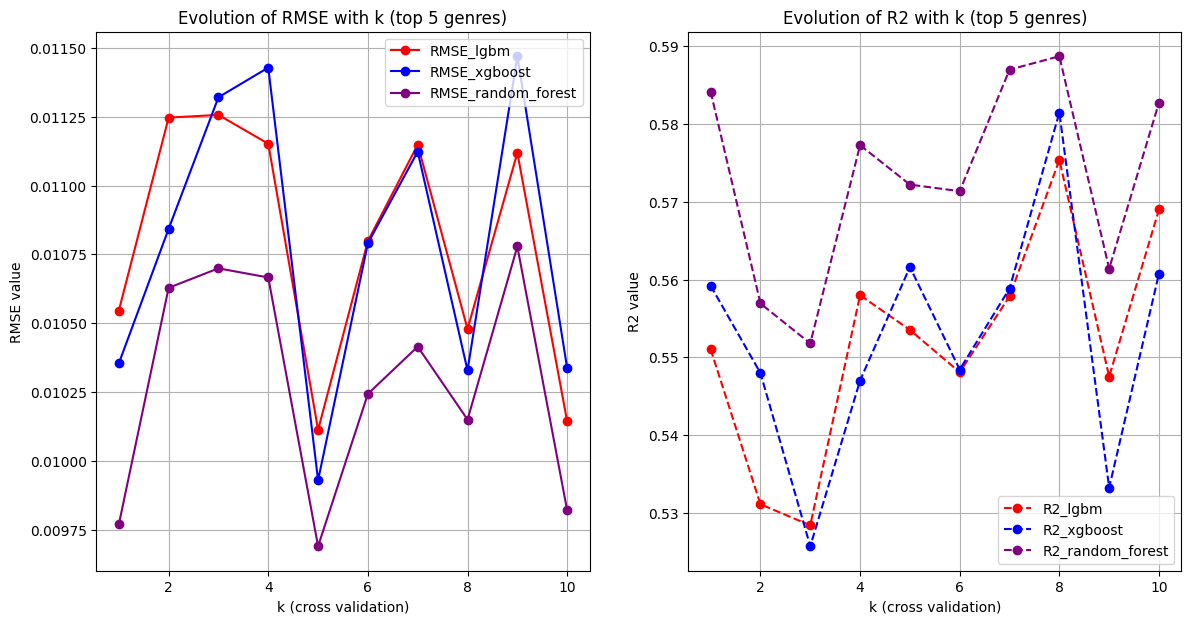

In [13]:


model_params = {
    'lgbm' : {
        'objective': 'rmse',
        'n_estimators' : 1000,
        'random_state' : random_state
    },
    'xgboost':{},
    'random_forest':{}
}

legends_rmse, legends_r2 = [], []
x_vals = range(1, n_splits+1)
colors = ['red', 'blue', 'purple', 'green'] 
fig, axs = plt.subplots(figsize=(14, 7))

model_names = list(model_params.keys())
model_metrics = {}
for model_no, model_name in enumerate(model_names):
    print(f"model_name: {model_name}")
    model = select_model(model_name, model_params[model_name])

    ################## TRAINING + EVALUATION ##################
    cv_results = cross_validate(
        model, 
        X_train, y_train, 
        cv=cv, 
        scoring=dict(r2=make_scorer(r2_score), e2=make_scorer(mean_squared_error)),
        return_estimator=False
    )
    model_metrics.update({model_name: cv_results})
    model_metrics[model_name]['test_e2_rmse'] = np.sqrt(model_metrics[model_name]['test_e2'])
    
    ################## PLOT METRICS ##################
    plt.subplot(121)
    plt.plot(x_vals, model_metrics[model_name]['test_e2'], '-o', color=colors[model_no])
    legends_rmse += [f'RMSE_{model_name}',]
    plt.subplot(122)
    plt.plot(x_vals, model_metrics[model_name]['test_r2'], '--o', color=colors[model_no])
    legends_r2 += [f'R2_{model_name}']
    


N_genres = len(df['genre'].value_counts())

plt.subplot(121)
plt.title(f"Evolution of RMSE with k (top {N_genres} genres)")
plt.ylabel('RMSE value')
plt.xlabel('k (cross validation)')
plt.legend(legends_rmse)
plt.grid()

plt.subplot(122)
plt.title(f"Evolution of R2 with k (top {N_genres} genres)")
plt.ylabel('R2 value')
plt.xlabel('k (cross validation)')
plt.legend(legends_r2)
plt.grid()

plt.show()

In [14]:
model_metrics

{'lgbm': {'fit_time': array([281.59153271,   3.99200034,   3.32300138,   4.21000075,
           3.28399754,   3.02799797,   3.04899549,   2.42799711,
           2.21099854,   2.43400073]),
  'score_time': array([0.15600109, 0.05499887, 0.08699775, 0.05100274, 0.04300094,
         0.04800129, 0.04500484, 0.04000187, 0.04300261, 0.03700042]),
  'test_r2': array([0.55104195, 0.5311368 , 0.52843499, 0.5579855 , 0.55352499,
         0.54809289, 0.55783607, 0.57533872, 0.54753441, 0.5689907 ]),
  'test_e2': array([0.01054538, 0.01124681, 0.01125663, 0.0111519 , 0.01011207,
         0.01079841, 0.01114851, 0.0104785 , 0.01111917, 0.01014286]),
  'test_e2_rmse': array([0.10269071, 0.10605099, 0.10609728, 0.10560257, 0.1005588 ,
         0.10391541, 0.10558653, 0.10236453, 0.10544748, 0.10071179])},
 'xgboost': {'fit_time': array([1.8956883 , 1.74700212, 1.51799989, 1.50599813, 1.49700284,
         1.49100041, 1.49000216, 1.57800174, 1.58000135, 1.50700378]),
  'score_time': array([0.00900221, 

In [15]:
for model_name in model_names:
    model_metrics[model_name]['RMSE_mean'] = np.mean(model_metrics[model_name]['test_e2_rmse'])
    model_metrics[model_name]['R2_mean'] = np.mean(model_metrics[model_name]['test_r2'])
    print(f"model_name: {model_name}\n\tRMSE_mean: {model_metrics[model_name]['RMSE_mean']}\n\tR2_mean: {model_metrics[model_name]['R2_mean']}\n")

model_name: lgbm
	RMSE_mean: 0.10390260818197347
	R2_mean: 0.5519917039305897

model_name: xgboost
	RMSE_mean: 0.1038564516636535
	R2_mean: 0.5524304341920128

model_name: random_forest
	RMSE_mean: 0.1013994299425958
	R2_mean: 0.5733342226768008



In [16]:
model_R2_max = model_names[np.argmax([model_metrics[model_name]['R2_mean'] for model_name in model_names])]
model_RMSE_min = model_names[np.argmin([model_metrics[model_name]['RMSE_mean'] for model_name in model_names])]
print(f">> R2 max: model '{model_R2_max}'\n>> RMSE min: model '{model_RMSE_min}'")

>> R2 max: model 'random_forest'
>> RMSE min: model 'random_forest'


# III - Train final model: RandomForest()

In [27]:
X_test = X_test.to_numpy()
y_test = y_test.to_numpy().ravel()

In [39]:
max_depths = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100]

rf_models = []
train_R2_list, test_R2_list = [], []
train_RMSE_list, test_RMSE_list = [], []
for max_depth in max_depths:
    rf = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
    rf_models.append(rf)
    
    # R2
    train_R2 = rf.score(X_train, y_train)
    train_R2_list.append(train_R2)
    
    test_R2 = rf.score(X_test, y_test)
    test_R2_list.append(test_R2)
    
    # RMSE
    y_train_pred = rf.predict(X_train)
    RMSE_train = np.sqrt(mean_squared_error(y_train_pred, y_train))
    train_RMSE_list.append(RMSE_train)
    
    y_test_pred = rf.predict(X_test)
    RMSE_test = np.sqrt(mean_squared_error(y_test_pred, y_test))
    test_RMSE_list.append(RMSE_test)
    
    print(f"max_depth: {max_depth} -> train_R2 = {train_R2} | test_R2 = {test_R2} | RMSE_train = {RMSE_train} | RMSE_test = {RMSE_test}")
    

max_depth: 1 -> train_R2 = 0.2992434849280978 | test_R2 = 0.2887652319303503 | RMSE_train = 0.129997228922548 | RMSE_test = 0.13007871588046782
max_depth: 2 -> train_R2 = 0.45100551892543905 | test_R2 = 0.4431551166829263 | RMSE_train = 0.1150626870914904 | RMSE_test = 0.11509775915118288
max_depth: 3 -> train_R2 = 0.5440895273224617 | test_R2 = 0.5347928930927783 | RMSE_train = 0.10485528063614338 | RMSE_test = 0.10520173978545604
max_depth: 4 -> train_R2 = 0.560524524706836 | test_R2 = 0.5476971821441224 | RMSE_train = 0.10294798366421205 | RMSE_test = 0.10373239339564407
max_depth: 5 -> train_R2 = 0.5740456862400216 | test_R2 = 0.5551557210317548 | RMSE_train = 0.10135193231887829 | RMSE_test = 0.10287355700830812
max_depth: 10 -> train_R2 = 0.66027308725449 | test_R2 = 0.5694342533324361 | RMSE_train = 0.0905139460775805 | RMSE_test = 0.10120908303767606
max_depth: 15 -> train_R2 = 0.7963099841571721 | test_R2 = 0.5698935358120643 | RMSE_train = 0.07008666478330201 | RMSE_test = 0.

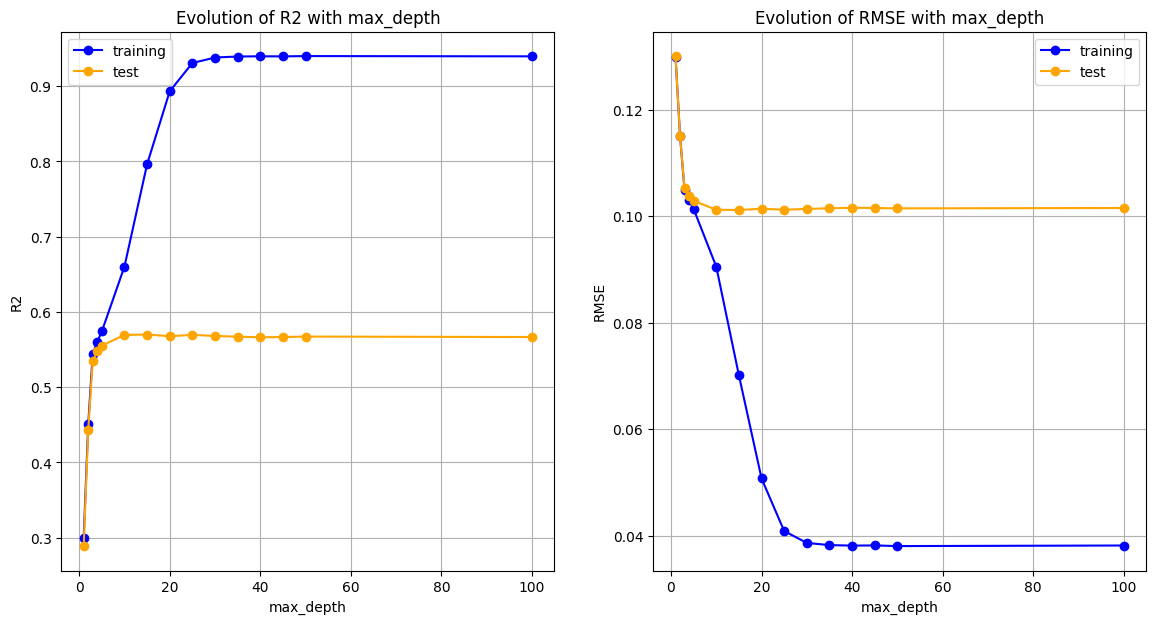

In [46]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

plt.subplot(121)
plt.plot(max_depths, train_R2_list, '-o', color='blue')
plt.plot(max_depths, test_R2_list, '-o', color='orange')
plt.title(f"Evolution of R2 with max_depth")
plt.ylabel('R2')
plt.xlabel('max_depth')
plt.legend(['training', 'test'])
plt.grid()

plt.subplot(122)
plt.plot(max_depths, train_RMSE_list, '--o', color='blue')
plt.plot(max_depths, test_RMSE_list, '--o', color='orange')
plt.title(f"Evolution of RMSE with max_depth")
plt.ylabel('RMSE')
plt.xlabel('max_depth')
plt.legend(['training', 'test'])
plt.grid()
plt.show()

### Export tree

In [53]:
from sklearn.tree import export_graphviz
import pydot

best_model_idx = np.argmax(test_R2_list)
print(f"Best model for max_depth = {max_depths[best_model_idx]}")
rf_opt = rf_models[best_model_idx]

# Extract the small tree
tree_small = rf_opt.estimators_[0]
tree_small

# Save the tree as a png image
export_graphviz(tree_small, out_file = '../report/img/small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('../report/img/small_tree.dot')
graph.write_png('../report/img/small_tree.png');

Best model for max_depth = 15


## References

- Features importance: [Understanding Feature Importance and How to Implement it in Python](https://towardsdatascience.com/understanding-feature-importance-and-how-to-implement-it-in-python-ff0287b20285)
- Features importance: [How to Calculate Feature Importance With Python](https://machinelearningmastery.com/calculate-feature-importance-with-python/)
- KFold: [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html)
- RandomForest: [sklearn.ensemble.RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
- RandomForest: [Random Forest in Python](https://towardsdatascience.com/random-forest-in-python-24d0893d51c0)